# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

#### Условия задачи:<br>
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

#### Описание данных
- Данные геологоразведки трёх регионов находятся в файлах:
    - geo_data_0.csv. Скачать датасет
    - geo_data_1.csv. Скачать датасет
    - geo_data_2.csv. Скачать датасет
    - id — уникальный идентификатор скважины;
    - f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
    - product — объём запасов в скважине (тыс. баррелей).

# 1. Загрузка и подготовка данных

In [1]:
#Подключим необходимые библиотеки для нашего проекта
import os
import urllib.request
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats as st
from numpy.random import RandomState
state = RandomState(12345)

In [2]:
#Загрузим файлы с папки /datasets/ Либо скачаем из интернета
Path('datasets').mkdir(parents=True, exist_ok=True)


def get_file(file_name, url):
    #Проверим есть ли файл
    if not os.path.exists(file_name):
        print(file_name, 'файл не найден, будет загружен из сети')
        _ = urllib.request.urlretrieve(url, file_name)

        
urls = {
    'geodata0': ('geo_data_0.csv','https://code.s3.yandex.net/datasets/geo_data_0.csv'),
    'geodata1': ('geo_data_1.csv','https://code.s3.yandex.net/datasets/geo_data_1.csv'),
    'geodata2': ('geo_data_2.csv','https://code.s3.yandex.net/datasets/geo_data_2.csv')
}

[get_file(*urls[k]) for k in urls]

#Присвоим 
data0 = pd.read_csv(urls['geodata0'][0])
data1 = pd.read_csv(urls['geodata1'][0])
data2 = pd.read_csv(urls['geodata2'][0])

In [3]:
#Выведем первые 5 строк каждого датасета
display(data0.head())
display(data1.head())
display(data2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [4]:
#Изучим датасеты методом info и describe
print('\n\n-------------------------Первый Датасет---------------------------------\n\n')
display(data0.info())
display(data0.describe())
print('\n\n-------------------------Второй Датасет---------------------------------\n\n')
display(data1.info())
display(data1.describe())
print('\n\n-------------------------Третий Датасет---------------------------------\n\n')
display(data2.info())
display(data2.describe())



-------------------------Первый Датасет---------------------------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347




-------------------------Второй Датасет---------------------------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408




-------------------------Третий Датасет---------------------------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [5]:
#Проверим на наличие дубликатов
print('Датасет №0, количество дубликатов: ',data0.duplicated().sum())
print('Датасет №1, количество дубликатов: ',data1.duplicated().sum())
print('Датасет №2, количество дубликатов: ',data2.duplicated().sum())

Датасет №0, количество дубликатов:  0
Датасет №1, количество дубликатов:  0
Датасет №2, количество дубликатов:  0


In [6]:
#Уникальные значения таблиц
display(data0.nunique())
display(data1.nunique())
display(data2.nunique())

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

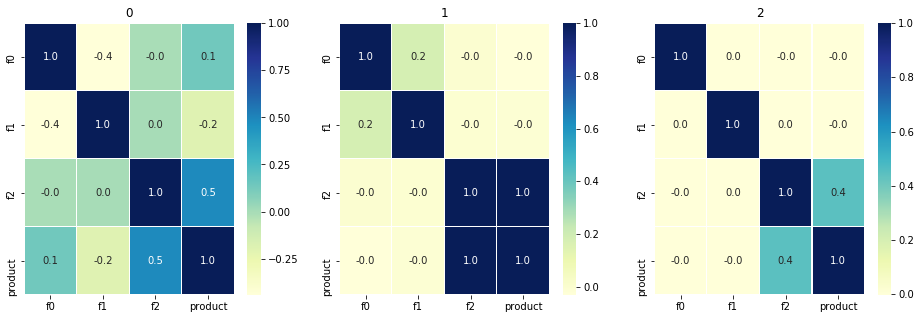

In [7]:
fig, ax = plt.subplots(1,3,figsize=(16,5))
for i,j in zip([data0,data1,data2],range(3)):    
    sns.heatmap(i.corr(),annot=True, linewidths=.1, fmt= '.1f', ax=ax[j], cmap="YlGnBu")
    ax[j].set_title(str(j))

In [8]:
#оценка корреляций признаков
display(data0.corr())
display(data1.corr())
display(data2.corr())

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


## Вывод:

- Все датасеты хорошо подготовлены, все типы данных указаны правильно, дубликатов не имеется. В каждом по 100 000 наблюдений.
- Признак F2 очень сильно коррелирует с product
- Имеются повторяющиеся значения в столбцах ID, видимо пробы брались несколько раз в одной и той же скважине.
- У второго датасета уникальных значений в product всего 12. Наша будущая модель может слишком хорошо прогнозировать. Посмотрим...

# 2. Обучение и проверка модели

In [9]:
#Создадим листы для хранения результатов прогнозирования и их метрик
# Через цикл проверим модели на всех трех датасетах и сохраним результаты метрик и прогнозирований в наши листы

rmse_list = []
predictions_list = []
score_list = []
target = []
predictions_df = pd.DataFrame()
target_df = pd.DataFrame()

for i,j in zip([data0,data1,data2],range(3)):
    X = i.drop(['product','id'], axis=1)
    y = i['product']
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, random_state=12345, test_size=0.25) 
    
    lr = LinearRegression(n_jobs = -1)
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_valid)
    rmse = np.sqrt(np.mean((y_valid-predictions)**2))
    rmse_list.append(rmse)
    predictions_list.append(predictions.mean())
    score_list.append(lr.score(X_train,y_train))
    target.append(i['product'].mean())
    target_df[j] = y_valid
    predictions_df[j] = predictions

In [10]:
#Создадим таблицу с имеющимися листами, чтобы сравнить результаты
target_df = target_df.reset_index(drop=True)
scorelist = pd.DataFrame(
    data=[rmse_list, score_list, predictions_list, target], 
    index=['RMSE','SCORE','PREDICTED MEAN', 'TARGET MEAN'], 
    columns=['region 1','region 2','region 3'])
scorelist

,region 1,region 2,region 3
RMSE,37.579422,0.893099,40.029709
SCORE,0.274239,0.999625,0.196614
PREDICTED MEAN,92.592568,68.728547,94.965046
TARGET MEAN,92.500000,68.825000,95.000000


### Вывод: 
<br>
<li>Очевидно, что среднее спрогнозированное и среднее target почти похоже.</li>
<li>Посмотрим на результаты которые мы получили у моделей:</li>
<Br><br>
<table width=400 style="margin-top:10px; margin-left:10px;">
    <tr><td></td>
        <td>RMSE</td>
        <td>SCORE</td>
    </tr>
    <tr><td>Регион №1</td>
        <td>37.5</td>
        <td>0.27</td>
    </tr>
    <tr><td>Регион №2</td>
        <td>0.89</td>
        <td>0.99</td>
    </tr>
    <tr><td>Регион №3</td>
        <td>40.02</td>
        <td>0.19</td>
    </tr>
</table>
<br><br>

<li>Модели первого региона и третьего показывают очень плохие результаты. Не стоит использовать их для выбора скважины в регионе.</li>
<li>Модель второго региона показыла очень хорошие результаты, но как мы и предвидели из-за того что у цели всего лишь 12 значений из 100 000 для модели было легко спрогнозировать правильные ответ. поэтому вторую модель также опасно использовать.</li>
<br>
<li>Предсказанное среднее и target среднее почти одинаково</li>
<br>
<table width=400 style="margin-top:10px; margin-left:10px;">
    <tr><td></td>
        <td>Predicted mean</td>
        <td>Target mean</td>
    </tr>
    <tr><td>Регион №1</td>
        <td>92.59</td>
        <td>92.50</td>
    </tr>
    <tr><td>Регион №2</td>
        <td>68.72</td>
        <td>68.82</td>
    </tr>
    <tr><td>Регион №3</td>
        <td>94.96</td>
        <td>95.00</td>
    </tr>
</table>
<br><br>

# 3. Подготовка к расчёту прибыли

In [11]:
#По условиям задачи : 

budget = 10000000000   #Бюджет на разработку скважин в регионе 10 млрд. рублей
total_reconnaissance = 500 #При разведке исследуют 500 точек
profit_wells = 200  # 200 лучших скважин для расчета прибыли
profit_from_one_barrel = 450   #Прибыль с одного барреля сырья 450 рублей
profit_from_one_product = 450000   #Доход с каждой единицы продукта 450 000 рублей

In [12]:
#Посчитаем цену за бурение одной скважины
well_drilling_price = budget / profit_wells
well_drilling_price

50000000.0

In [13]:
#Посчитаем Достаточный объем сырья для безубыточной разработки новой скважины
min_product_mean  = well_drilling_price/profit_from_one_product
min_product_mean

111.11111111111111

In [14]:
#Напишем функцию для расчета прибыли по выбранным скважинам и предсказаниям модели. 

def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return (450000 * selected.sum() - (budget))

In [15]:
#Посчитаем прибыль на каждый регион
print('Прибыль первого региона : {:.2f} млрд рублей'.format(revenue(target_df[0], predictions_df[0],200)/10**9))
print('Прибыль второго региона : {:.2f} млрд рублей'.format(revenue(target_df[1], predictions_df[1],200)/10**9))
print('Прибыль третьего региона :{:.2f} млрд рублей'.format(revenue(target_df[2], predictions_df[2],200)/10**9))

Прибыль первого региона : 3.32 млрд рублей
Прибыль второго региона : 2.42 млрд рублей
Прибыль третьего региона :2.71 млрд рублей


### Вывод:
Минимальный объем сырья в каждой скважине должен составлять 111 тыс барелей. Наши средние предсказания и средние target трех регионов не проходят минимальный порог<br><BR><BR>

# 4. Расчёт прибыли и рисков 

In [16]:
#Техникой bootstrap посчитаем среднюю прибыль , 95% доверительный интервал и риск убытков для первого региона
import scipy as sp
import scipy.stats

revenues = []

for i in range(1000):
    target_subsample = target_df[0].sample(n=500, replace=True, random_state=state)
    probs_subsample = predictions_df[0][target_subsample.index]
    revenues.append(revenue(target_subsample, probs_subsample, 200))

revenues = pd.Series(revenues)
lower = revenues.quantile(0.025)
mean = revenues.mean()
risks = (revenues < 0).mean()* 100
print("Средняя прибыль:", mean/10**9)
print("2.5%-квантиль:", lower/10**9)
print("Риск: {}".format(risks))
final_revenues = []
confidence_interval = (revenues.quantile(0.025), revenues.quantile(0.975))
print('95% доверительный интервал: ', confidence_interval)
final_revenues.append(('region 1', mean/10**9, lower/10**9, confidence_interval, risks))

Средняя прибыль: 0.4259385269105923
2.5%-квантиль: -0.10209009483793653
Риск: 6.0
95% доверительный интервал:  (-102090094.83793654, 947976353.358369)


In [17]:
#Техникой bootstrap посчитаем среднюю прибыль , 95% доверительный интервал и риск убытков для второго региона
revenues = []

for i in range(1000):
    target_subsample = target_df[1].sample(n=500, replace=True, random_state=state)
    probs_subsample = predictions_df[1][target_subsample.index]
    revenues.append(revenue(target_subsample, probs_subsample, 200))

revenues = pd.Series(revenues)
lower = revenues.quantile(0.025)
mean = revenues.mean()
risks = (revenues < 0).mean()* 100
print("Средняя прибыль:", mean/10**9)
print("2.5%-квантиль:", lower/10**9)
print("Риск: {}".format(risks))
confidence_interval = (revenues.quantile(0.025), revenues.quantile(0.975))
print("Риск:", (revenues < 0).mean()* 100, '%')
print('95% доверительный интервал: ', confidence_interval)
final_revenues.append(('region 2', mean/10**9, lower/10**9, confidence_interval, risks))

Средняя прибыль: 0.5182594936973249
2.5%-квантиль: 0.1281232314330863
Риск: 0.3
Риск: 0.3 %
95% доверительный интервал:  (128123231.43308629, 953612982.0669085)


In [18]:
#Техникой bootstrap посчитаем среднюю прибыль , 95% доверительный интервал и риск убытков для третьего региона
revenues = []
total_wells = 500
profit_wells = 200

for i in range(1000):
    target_subsample = target_df[2].sample(n=total_wells,replace=True, random_state=state)
    probs_subsample = predictions_df[2][target_subsample.index]
    revenues.append(revenue(target_subsample, probs_subsample, profit_wells))

revenues = pd.Series(revenues)
lower = revenues.quantile(0.025)
mean = revenues.mean()
risks = (revenues < 0).mean()* 100
#interval = interval = st.t.interval(0.95, len(revenues)-1, revenues.mean()/10**9, revenues.sem()/10**9)
print("Средняя прибыль:", mean/10**9)
print("2.5%-квантиль:", lower/10**9)
confidence_interval = (revenues.quantile(0.025), revenues.quantile(0.975))
print('95% доверительный интервал: ', confidence_interval)
print("Риск:", (revenues < 0).mean()* 100, '%')
final_revenues.append(('region 3', mean/10**9, lower/10**9, confidence_interval, risks))

Средняя прибыль: 0.42019400534405005
2.5%-квантиль: -0.11585260916001143
95% доверительный интервал:  (-115852609.16001143, 989629939.844574)
Риск: 6.2 %


In [20]:
#Выведем все результаты в одной таблице для сравнения.
report_df = pd.DataFrame(final_revenues, columns=['Region', 'Mean Revenue', 'Quantile 2.5%', 'Interval 95%', 'Risks %'])
cm = sns.light_palette("green", as_cmap=True)
s = report_df.style.background_gradient(cmap=cm)
s

,Region,Mean Revenue,Quantile 2.5%,Interval 95%,Risks %
0,region 1,0.425939,-0.10209,"(-102090094.83793654, 947976353.358369)",6
1,region 2,0.518259,0.128123,"(128123231.43308629, 953612982.0669085)",0.3
2,region 3,0.420194,-0.115853,"(-115852609.16001143, 989629939.844574)",6.2


### Вывод: 
- Второй регион показывает хорошие результаты. Но так как мы знаем, что второй регион слишком рискованный, слишком странные у него данные - мы не можем его выбрать.
- Поэтому для бурения будет лучше выбрать первый регион. Но учитывая оценки прогнозирования, я бы вообще не принимал никаких серьезных решений на основе полученных результатов.

# Общий вывод: 

- Мы получили три датасета - три разные региона для прогнозирования объема сырья и прибыли. Все датасеты были хорошо подготовлены, не имелось никаких дубликатов, пустых значений. Но второй датасет оказался сильно отличимым от других, у него в столбце product были лишь 12 уникальных значений. Что позволило нашей модели хорошо делать прогнозы по второму региону ,поэтому нам нельзя использовать эту модель и сам регион. Слишком рискованно. 
- Исходя из всех результатов моделей мы получили такие результаты:
    - Регион 1: RMSE : 37.5  ; Score 0.27
    - Регион 2: RMSE : 0.89  ; Score 0.99
    - Регион 3: RMSE : 40.02 ; Score 0.19

- Провели расчет прибыли и пришли к выводу, что минимальный объем сырья должен составлять 111 тыс барелей. Наши средние показатели трех регионов не доходят до минимального порога.
- Исходя из всех полученных данных: второй регион имеет наибольшие шансы на получение прибыли. Но учитывая тот факт, что все модели показали ужасные результаты, и из худшего мы выбрали наибольшее лучший, я бы не советовал использовать эти данные для принятия окончательных решений. 

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован